In [1]:
#Packages

import os
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools

from copy import deepcopy
from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix
from autocatalytic_cores_lib import *
import matplotlib.pyplot as plt
from scipy.stats import linregress


In [2]:
#Parameters definition

ttot = float(100.0) # Total time for the simulation
dt = 1.0E-3 # Timestep

npas = int(ttot//dt)

REALIZATIONS = 5 # Number of simulations

In [3]:
# Type 1 simulation

# Main function to run simulations  (THE OLDEST VERSION) WITH THERMODYNAMICS

def Type1(ttot, dt, REALIZATIONS, reverse, law):
    # Number of steps
    npas = int(ttot / dt)

    file_path1 = "StoichioPLUS.dat"
    file_path2 = "StoichioMINUS.dat"
    
    # Read the stoichiometric matrix into a NumPy array
    S = np.loadtxt(file_path1, delimiter=' ')
    S1 = np.loadtxt(file_path2, delimiter=' ')
   
    Sp = S1 - S
    
    # Inizialization of compt
    compt = 0
    temps = 0
    survival = []

    [shutil.rmtree(os.path.join('output', f)) if os.path.isdir(os.path.join('output', f)) else os.unlink(os.path.join('output', f)) for f in os.listdir('output')]
    
    for r in range(REALIZATIONS):
        resY = open("output/Time_%d.dat" % (r + 1), "w")
        resY.truncate(0)
        
        #X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)] # Initialize constant values for the original species
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(len(Sp[0]))] # Initialize constant values for the invader species
    
        kf = [random.uniform(0.95, 1.05) for _ in range(len(Sp[0]))] # Initialize constant values for the forward rates
        #kf[2]=500
        mu_0 = [random.uniform(-1, 1) for _ in range(len(Sp[0]))] # For the thermodynamical feasibility of the reactions

        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(Sp.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)  # kr should be a fixed array
        

        Ytot = sum(Y)
     
        for i in range(npas // 100):  # Two timescales to print not too much
            temps = (i * 100) * dt
            resY.write(f"{round(temps, 1)}")
            for y in Y:
                resY.write(f" {round(y, 3)}")
            resY.write("\n")
            
            for j in range(100):
                curr = np.zeros(len(Sp[0]))
                

                # If I have MAL, I update the currents each iteration, ONLY REVERSED ONE WILL HAVE THE BACKWARD CURRENT, THIS MUST BE DONE BECAUSE S AND S1 ARE A PRIORI FROM THE REVERSIBILITY
                if law == "MAL":
                    ratef = kf[:]
                    rater = deepcopy(kr)  # Make a deep copy of kr to ensure kr is not modified
                    
                    #print(kr)
                    
                    for l in range(len(Sp[0])):
                        for s, p in zip(Y, S[:, l]):  # Updating the currents for each reaction each time step
                            ratef[l] *= pow(s, p)
                        for s, p in zip(Y, S1[:, l]):  # Same but backward
                            rater[l] *= pow(s, p)   
                        if reverse:
                            curr[l] = np.array(ratef[l]) - np.array(rater[l])
                        else:
                            curr[l] = np.array(ratef[l])
                    
                    #print(kr)

                # If I have MM, the forward rate will change, the backward will still be MAL
                if law == "MM":
                    ratef = np.ones(len(kf))
                    rater = deepcopy(kr)  # Make a deep copy of kr to ensure kr is not modified

                    for l in range(len(Sp[0])):
                        prod = 1
                        for s, p in zip(Y, S[:, l]):  # Updating the currents for each reaction each time step
                            prod *= pow(s, p)
                        ratef[l] = prod / (kf[l] + prod)
                       
                        for s, p in zip(Y, S1[:, l]):  # Same but backward
                            rater[l] *= pow(s, p)  

                        if reverse:
                            curr[l] = ratef[l] - rater[l]
                        else:
                            curr[l] = ratef[l]
                
                # ODE 
                Y += dt * np.dot(Sp, curr)  # Solving a timestep ODE for the vector of invaders
                Y[Y < 0] = 0  # Non-negativity condition
                Ytot = sum(Y)
        
        
        if Ytot >= 0.2:  # Threshold for survival
            compt += 1
            survival.append(True)
        else: 
            survival.append(False)

        resY.close()  # Saving and closing the open files
        print("Realization done")
    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [5]:
os.makedirs('./output/', exist_ok=True)

In [6]:
survival = Type1( ttot, dt, REALIZATIONS, reverse = True, law = "MAL")

Realization done
Realization done
Realization done
Realization done
Realization done
5/5 Realizations led to successful invasion


In [7]:
os.makedirs('./output/images/', exist_ok=True)

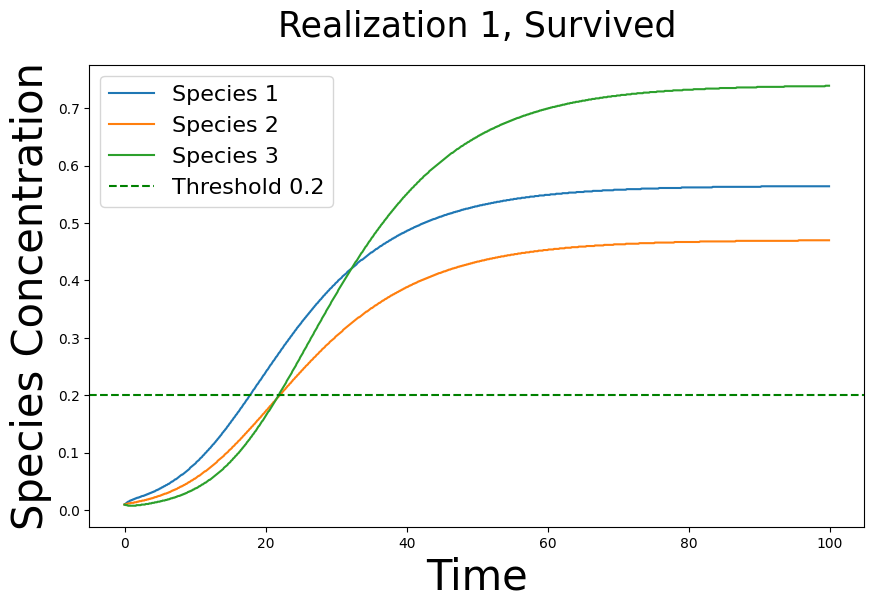

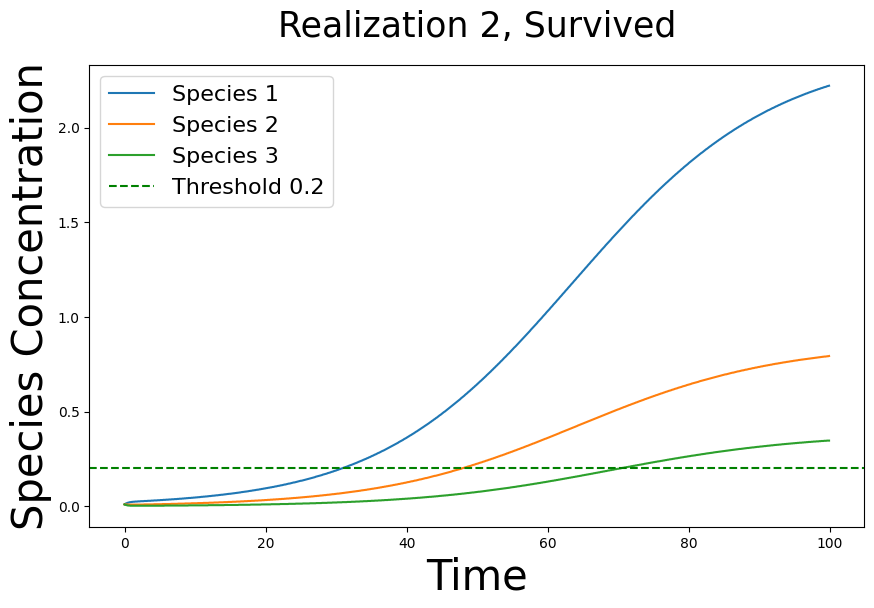

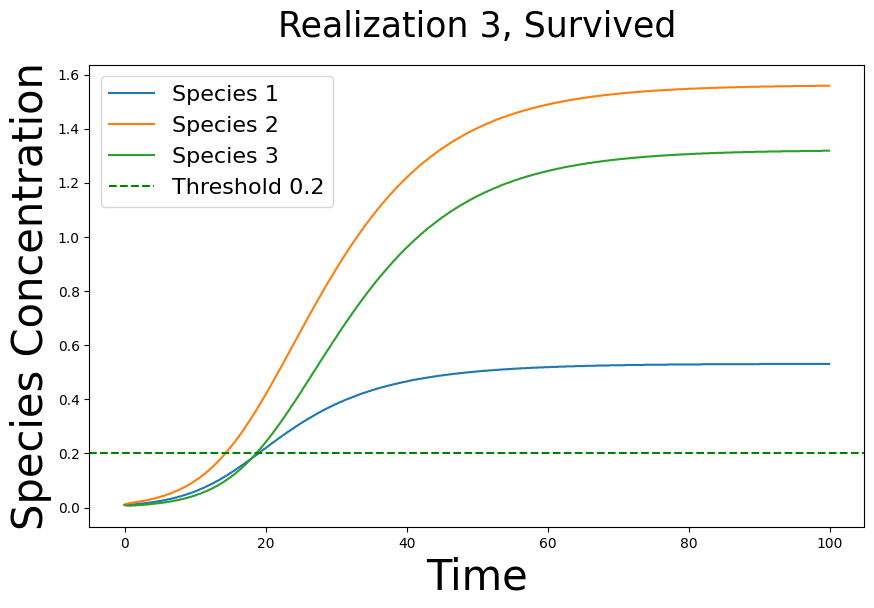

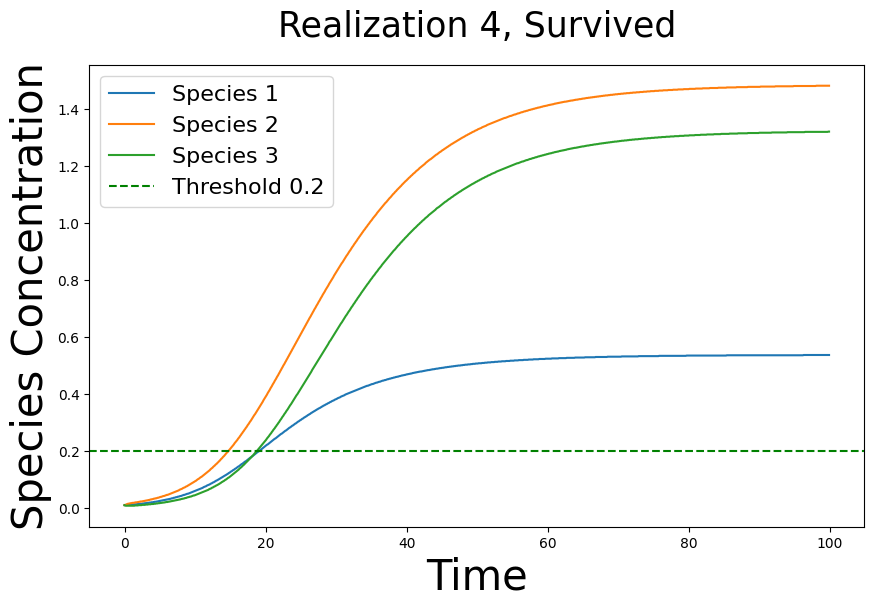

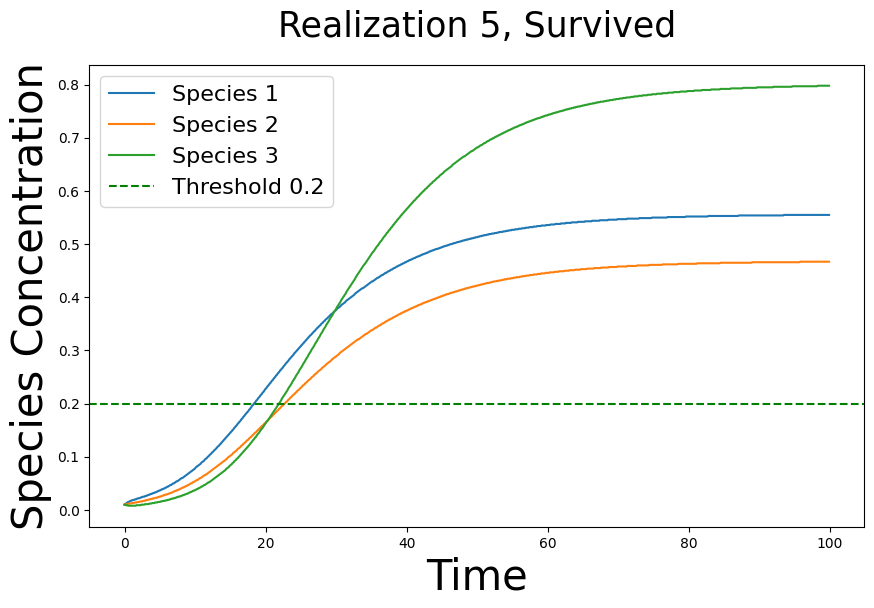

In [8]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Folder path to take data
folder_path = "output"

# Finding "Time_" files and sort them
file_list = glob.glob(os.path.join(folder_path, "Time_*"))
file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

# Plotting the files based on their autocatalysis
for index, (file, survived) in enumerate(zip(file_list, survival)):
    # Read the data
    data = pd.read_csv(file, delimiter='\s+', header=None)
    
    # Extract time and species concentration columns
    time = data.iloc[:, 0]
    species_data = data.iloc[:, 1:]
    
    plt.figure(figsize=(10, 6))
    
    # Plotting each species concentration
    for species_idx in range(species_data.shape[1]):
        plt.plot(time, species_data.iloc[:, species_idx], label=f'Species {species_idx+1}')
    
    # Adding the threshold
    plt.axhline(y=0.2, color='green', linestyle='--', label='Threshold 0.2')

    # Title and labels
    title = f'Realization {index+1}'
    title += f', {"Survived" if survived else "Did not Survive"}'
    plt.title(title, fontsize=25, pad=20)
    plt.xlabel('Time', fontsize=30)
    plt.ylabel('Species Concentration', fontsize=30)
    
    # Adding a legend
    plt.legend(loc='best', fontsize=16)

    # Saving and showing
    plt.savefig(f"./output/images/realization_{index+1}.pdf")
    plt.show()
